# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
def check_missing_values(df):
    # Вычисляем количество пропущенных значений для каждого столбца
    missing_values = df.isnull().sum()

    # Вычисляем процент пропущенных значений для каждого столбца
    total_values = len(df)
    missing_percent = ((missing_values / total_values) * 100).round(2)

    # Создаем новый столбец "строк пропущено" и вычисляем количество строк с хотя бы одним пропущенным значением
    missing_data = pd.DataFrame({'Столбец': missing_values.index, 'Пропущено в %': missing_percent.values})
    missing_data['Строк пропущено'] = df.isnull().any(axis=1).sum()

    # Сортируем датафрейм по убыванию процента пропущенных значений
    missing_data = missing_data.sort_values(by='Пропущено в %', ascending=False)

    return missing_data

In [3]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
792,e12051793m,VW Polo VI,economy,petrol,4.02,2015,87263,2015,34.07,electro_bug
97,N18957837j,VW Polo,economy,petrol,4.28,2012,25882,2017,44.69,engine_fuel
356,j-2201624B,Kia Sportage,standart,petrol,5.24,2014,55640,2017,39.54,engine_overheat
301,Q-1696362K,Skoda Rapid,economy,petrol,4.82,2013,39096,2018,43.78,gear_stick
352,s16218530z,Smart ForTwo,economy,petrol,2.88,2013,39450,2019,30.60,gear_stick


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [4]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
379744,k21732040N,b-1350184G,v1H,2020-02-10,0.92,93,1298,58,93.165548,0,5402.480389,0,6.167405,0.001
619725,C74570848M,r67742622z,n1n,2020-02-29,4.84,52,671,35,72.000000,1,1797.722974,0,-2.235432,6.225
98546,T11392225L,H-1873611C,v1V,2020-02-02,4.18,281,3929,32,63.000000,1,971.306524,0,12.097646,-1.506
655918,B11922223Q,u-2300894n,D1w,2020-02-29,4.30,850,10195,38,83.000000,3,1927.977025,0,2.972538,43.230
395471,b22756062P,c-1171224N,g1T,2020-03-16,5.26,14,109,38,67.000000,1,502.767924,0,1.511819,41.484


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [5]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
3547,26,8.7,178,18.0,G18731004m,1,2019-10-1
10165,25,6.2,1426,3.0,L21966981S,1,2018-8-9
5673,24,8.5,305,12.0,U13341664e,1,2020-5-3
7414,44,8.6,1019,16.0,n14237361v,0,2021-2-5
2621,36,9.8,74,20.0,g77944625d,1,2019-12-6


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [6]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
83081,w12773963K,EL,2020-3-8 18:2,reparking,1.0,28
70551,v22456431E,NW,2021-9-11 10:25,repair,6.1,23
130682,w-1633549j,WB,2021-5-18 20:47,repair,6.1,23
57966,W17258092O,WW,2019-5-16 20:0,repair,5.0,18
22503,B11239506t,YZ,2020-3-4 11:46,reparking,1.0,32


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

## 1.Возьмите датасет rides_info с информацией о поездках и проведите группировку по каждой машине отдельно.
## 2.Для каждой машины (то есть для каждого car_id) подсчитайте несколько признаков:
- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.

In [7]:
# Группировка по каждой машине и расчет статистик
grouped_rides = rides_info.groupby('car_id').agg(
    
    min_rating=('rating', 'min'),
    avg_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count')
).reset_index()

grouped_rides.head(1)

,car_id,min_rating,avg_rating,total_distance,max_speed,total_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174


## 3. Добавьте минимум 3 признака на свой выбор

In [8]:
# 1. Расчет частоты остановок и стартов на 100 км
rides_info['stops_per_100km'] = (rides_info['stop_times'] / rides_info['distance']) * 100

# 2. Расчет процента поездок с превышением средней скорости выше 45 км/ч
rides_info['speed_over_45'] = rides_info['speed_avg'] > 45
percentage_over_45 = rides_info.groupby('car_id')['speed_over_45'].mean() * 100

# 3. Среднее отклонение скорости от средней по автопарку
avg_speed_overall = rides_info['speed_avg'].mean()
rides_info['speed_deviation_from_avg'] = abs(rides_info['speed_avg'] - avg_speed_overall)
avg_speed_deviation_per_car = rides_info.groupby('car_id')['speed_deviation_from_avg'].mean()

# Объединение новых признаков с уже существующими данными
new_features = pd.DataFrame({
    'car_id': rides_info['car_id'].unique(),
    'stops_per_100km': rides_info.groupby('car_id')['stops_per_100km'].mean(),
    'percentage_speed_over_45': percentage_over_45,
    'avg_speed_deviation_from_avg': avg_speed_deviation_per_car
}).reset_index(drop=True)

grouped_rides = pd.merge(grouped_rides, new_features, on='car_id', how='left')

# Дополнительные признаки
additional_features = rides_info.groupby('car_id').agg(
    avg_stop_times=('stop_times', 'mean'),
    avg_deviation_normal=('deviation_normal', 'mean')
).reset_index()

# Объединение дополнительных признаков с уже существующими данными
enhanced_grouped_rides = pd.merge(grouped_rides, additional_features, on='car_id', how='left')

# Вывод первой строки обновленного DataFrame для проверки
enhanced_grouped_rides.head(1)

,car_id,min_rating,avg_rating,total_distance,max_speed,total_rides,stops_per_100km,percentage_speed_over_45,avg_speed_deviation_from_avg,avg_stop_times,avg_deviation_normal
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174,0.118979,51.724138,11.85128,0.816092,-6.136672


- Частота остановок и стартов на 100 км `stops_per_100km`. Показывает, сколько раз в среднем автомобиль останавливается и снова начинает движение на каждые 100 км пройденного пути. Это может помочь выявить потенциальный износ тормозной системы и двигателя.

- Процент поездок с превышением средней скорости выше 45 км/ч `percentage_speed_over_45`. Отражает долю поездок, во время которых средняя скорость превышала 45 км/ч. Этот признак может указывать на агрессивное вождение, что увеличивает риск износа и поломок.

-  Среднее отклонение скорости от средней по автопарку `avg_speed_deviation_from_avg`. Представляет собой среднее абсолютное отклонение средней скорости каждого автомобиля от средней скорости по всему автопарку. Это может помочь выявить автомобили, чья эксплуатация значительно отличается от средней, что потенциально может свидетельствовать о повышенном риске износа или поломок.

- Среднее количество остановок на поездку `avg_stop_times`. Это может указывать на стиль вождения или типы маршрутов, которые выбирает водитель.

- Среднее отклонение от нормы `avg_deviation_normal`.

# 4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

In [10]:
# Используем merge для соединения car_train и enhanced_grouped_rides по car_id
full_car_info = pd.merge(car_train, enhanced_grouped_rides, on='car_id', how='left')

full_car_info.head(1)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,avg_rating,total_distance,max_speed,total_rides,stops_per_100km,percentage_speed_over_45,avg_speed_deviation_from_avg,avg_stop_times,avg_deviation_normal
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,174,0.287586,45.402299,8.088746,3.62069,-0.120391


## 5.Подключите информацию про водителей (driver_info) и про ремонт машин (fix_info).  Добавьте минимум 3 любых признака с каждого датасета

Я буду использовать метод merge() для объединения датасетов по соответствующим ключам. 


In [11]:
# Присоединяем rides_info к full_car_info по car_id
full_car_rides = pd.merge(full_car_info, rides_info, on='car_id', how='left')

# Присоединяем driver_info к full_car_rides по user_id
full_car_drivers = pd.merge(full_car_rides, driver_info[['user_id', 'age', 'user_rating', 'user_time_accident']], on='user_id', how='left')

# Присоединяем fix_info к full_car_drivers по car_id, выбирая нужные столбцы
final_df = pd.merge(full_car_drivers, fix_info[['car_id', 'fix_date', 'work_type', 'destroy_degree']], on='car_id', how='left', suffixes=('', '_fix'))

final_df.head(1)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,deviation_normal,stops_per_100km_y,speed_over_45,speed_deviation_from_avg,age,user_rating,user_time_accident,fix_date,work_type,destroy_degree
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.0,0.3566,False,5.01227,38,7.4,2.0,2019-8-10 9:29,reparking,1.0


In [12]:
# Используем функцию для анализа датафрейма train_df_cleaned
missing_data_summary_5 = check_missing_values(final_df)
missing_data_summary_5

,Столбец,Пропущено в %,Строк пропущено
38,user_time_accident,13.17,1943425
27,speed_max,0.45,1943425
31,user_ride_quality,0.37,1943425
0,car_id,0.00,1943425
23,rating,0.00,1943425
24,ride_duration,0.00,1943425
25,ride_cost,0.00,1943425
26,speed_avg,0.00,1943425
28,stop_times,0.00,1943425
29,distance,0.00,1943425


Метод был выбран с учётом необходимости объединения информации из различных источников для получения полной картины состояния автопарка, включая характеристики водителей и историю обслуживания каждого автомобиля. В данном случае, ключевой элемент связи — `rides_info`, который позволяет связать информацию о водителях `driver_info` и информацию о ремонтах `fix_info` с конкретными автомобилями `full_car_info` через поездки. Выбор такого подхода направлен на создание основы для комплексного анализа, который может включать изучение взаимосвязи между характеристиками водителя и состоянием автомобиля, анализ влияния ремонтов на общую оценку автомобилей, и др. аспекты, важные для управления автопарком и повышения качества обслуживания клиентов.

Из `driver_info` выбраны колонки: `age`, `user_rating`, `sex`

- `age`: Возраст водителя может быть важным фактором, влияющим на стиль вождения, опыт и, потенциально, на безопасность поездок.
- `user_rating`: Рейтинг водителя напрямую отражает удовлетворенность клиентов услугами водителя. Это ключевой показатель качества сервиса.
- `sex`: Предполагаю, что пол водителя включён в анализ, возможно, для исследования статистических различий в показателях вождения или предпочтениях клиентов.

Из `fix_info`выбраны колонки: `fix_date`, `work_type`, `destroy_degree`

`fix_date`: Дата последнего ремонта может помочь оценить текущее техническое состояние автомобиля и планировать будущее обслуживание.
`work_type`: Тип проведённых работ дает понимание о характере вмешательства в автомобиль, будь то регулярное техобслуживание или устранение неисправности.
`destroy_degree`: Степень повреждения автомобиля при последнем ремонте может указывать на серьёзность происшествий или износа, с которыми автомобиль сталкивался в прошлом.

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [10]:
#!pip install catboost shap -q

In [13]:
# Сразу дропаем 
# - константы;
# - уникальные значения (в том числе в тесте; как правило, это ID-шники по типу car_id).

## Определение столбцов с константными значениями
constant_columns = [col for col in final_df.columns if final_df[col].nunique() == 1]

# Определение столбцов с уникальными значениями (исключая NaN)
unique_value_columns = [col for col in final_df.columns if final_df[col].nunique() == final_df.shape[0]]

# Уникальные значения
id_columns = ['user_id', 'car_id', 'ride_id']

# Объединение списков столбцов для удаления
columns_to_drop = list(set(constant_columns + unique_value_columns + id_columns))

# Удаление столбцов из final_df
final_df_cleaned = final_df.drop(columns=columns_to_drop)

print(f"Удалены столбцы: {columns_to_drop}")

pd.set_option('display.max_columns', None)
final_df_cleaned.head(1)

Удалены столбцы: ['user_id', 'total_rides', 'ride_id', 'car_id']


,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,avg_rating,total_distance,max_speed,stops_per_100km_x,percentage_speed_over_45,avg_speed_deviation_from_avg,avg_stop_times,avg_deviation_normal,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,stops_per_100km_y,speed_over_45,speed_deviation_from_avg,age,user_rating,user_time_accident,fix_date,work_type,destroy_degree
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,0.287586,45.402299,8.088746,3.62069,-0.120391,2020-01-01,5.72,220,3514,42,NaN,6,1682.556402,0,0.52475,0.0,0.3566,False,5.01227,38,7.4,2.0,2019-8-10 9:29,reparking,1.0


Датасет весьма большой и чтобы начать оптимизировать компьют, изначально переведу типы данных из 64 разрядных в 32 разрядные. Для этого напишу функцию `convert_dtypes`.

In [14]:
def convert_dtypes(final_df_cleaned):
    """
    Преобразует типы данных столбцов в датасете final_df_cleaned:
    int64 в int32 и float64 в float32.

    Параметры:
    final_df_cleaned (pd.DataFrame): Исходный датасет для преобразования.

    Возвращает:
    pd.DataFrame: Датасет с преобразованными типами данных.
    """
    for column in final_df_cleaned.columns:
        if final_df_cleaned[column].dtype == 'int64':
            final_df_cleaned[column] = final_df_cleaned[column].astype('int32')
        elif final_df_cleaned[column].dtype == 'float64':
            final_df_cleaned[column] = final_df_cleaned[column].astype('float32')
    
    return final_df_cleaned

final_df_cleaned = convert_dtypes(final_df_cleaned)

In [15]:
final_df_cleaned.shape

(13970460, 38)

Почти 14 миллионов наблюдений, это очень много. Для того чтобы продолжить выполнение задания, оптимизируем процесс и сократим выборку до 20% от первоначальой выборки.

In [16]:
sampled_df = final_df_cleaned.sample(frac=0.2, random_state=42)
sampled_df.shape

(2794092, 38)

Осталось почти 3 миллиона наблюдений, все еще много, но думается, с таким набором шансов на успешный feature importance повышаются :)

In [ ]:
# Посмотрим на репрезентативность нашей выборки, на основании следующих переменных
variables = ['car_rating', 'avg_rating', 'user_rating', 'age', 'total_distance']

for var in variables:
    plt.figure(figsize=(10, 4))
    sns.histplot(final_df_cleaned[var], color="blue", label="Исходный датасет", kde=True, stat="density", linewidth=0)
    sns.histplot(sampled_df[var], color="red", label="Выборка", kde=True, stat="density", linewidth=0, alpha=0.5)
    plt.legend()
    plt.title(f'Распределение {var}')
    plt.show()

Проведем t-test

In [ ]:
from scipy.stats import ttest_ind

# Для каждой ключевой переменной выполним t-тест
results = []
for var in variables:
    stat, p = ttest_ind(final_df_cleaned[var], sampled_df[var])
    results.append((var, stat, p))

# Выведем результаты
print("Переменная\tСтатистика t\tP-value")
for res in results:
    print(f"{res[0]}\t{res[1]:.2f}\t{res[2]:.3f}")

### Способ № 1 Feature importance (CatBoost)

In [19]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Подготовка данных
X = sampled_df.drop(['target_class'], axis=1, errors='ignore')  # Удаляем только целевую переменную
y = sampled_df['target_class'].fillna(0)

# Категориальные колонки
cat_features = ['model', 'car_type', 'fuel_type', 'ride_date', 'fix_date', 'work_type']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Создание объектов Pool
pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_test = Pool(X_test, y_test, cat_features=cat_features)

# Инициализация и обучение модели CatBoost
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=10,
    cat_features=cat_features,
    verbose=100,
    early_stopping_rounds=100,
    random_seed=42
)

model.fit(pool_train, eval_set=pool_test, use_best_model=True)

# Вывод важности признаков
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame(feature_importances, index=X_train.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)
importance_df

0:	learn: 1.5341200	test: 1.5339644	best: 1.5339644 (0)	total: 15.4s	remaining: 25m 26s
99:	learn: 0.0038430	test: 0.0012890	best: 0.0012890 (99)	total: 30m 51s	remaining: 0us

bestTest = 0.001289038056
bestIteration = 99



,Importance
avg_stop_times,13.661148
avg_rating,13.550781
min_rating,13.081249
max_speed,12.977432
fix_date,12.110997
target_reg,11.537035
avg_speed_deviation_from_avg,10.773911
percentage_speed_over_45,2.391606
user_time_accident,1.967124
stops_per_100km_x,1.781896


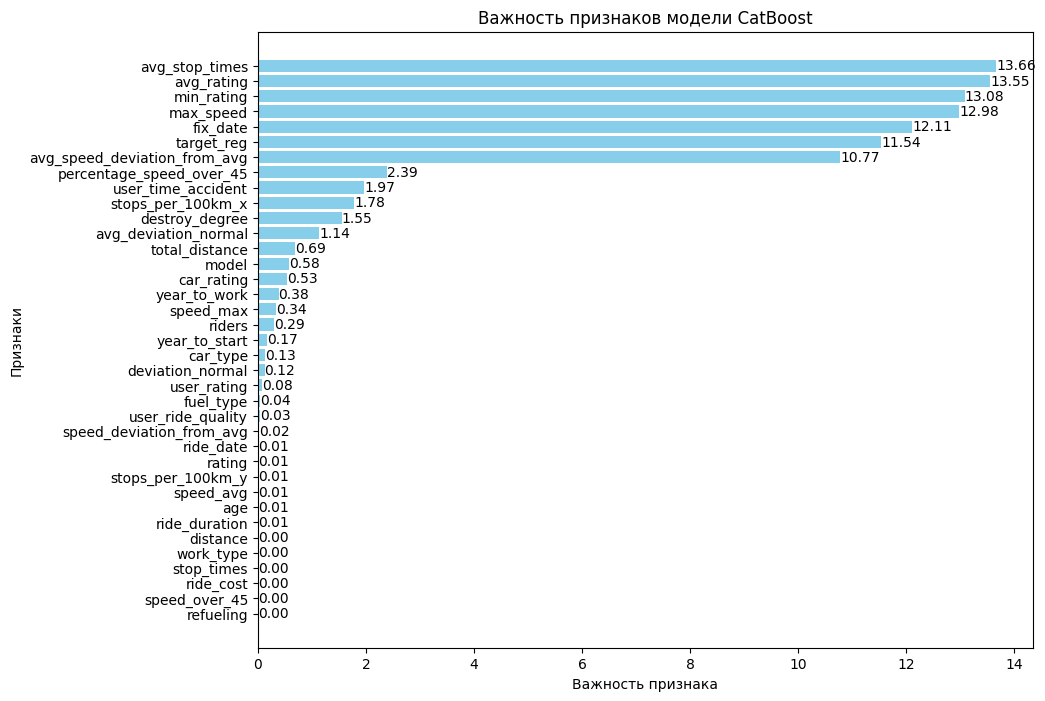

In [18]:
# Сортировка значений важности признаков по убыванию
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=True)

# Создание горизонтальной столбчатой диаграммы
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df_sorted.index, importance_df_sorted['Importance'], color='skyblue')

# Добавление значений на диаграмме
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", 
             va='center', ha='left')

plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели CatBoost')
plt.show()

### Способ № 2 Phink

In [15]:
# !pip install phik -q

In [ ]:
# import phik
# from phik import resources, report
# import seaborn as sns

# # Вычисляем корреляцию Phik 
# phik_matrix = final_df_cleaned.phik_matrix()

# # Отображение корреляционной матрицы Phik
# print(phik_matrix)

# # Визуализация корреляционной матрицы 
# plt.figure(figsize=(12, 10))
# sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="viridis")
# plt.title("Phik Correlation Matrix")
# plt.show()

‪![ошибка](1.jpg)
Способ мне не понравился, т.к., на мой взгляд, он пораждает различного рода проблемы, основной из которых является необходимость решить что-то с колонкой `fix_date`. Самым разумным представляется использовать какие-то конкретные данные из нее, например день или время поломки, а не всю дату целиком. Можно еще и дропнуть ее, но в таком случае, мы можем потерять потенциальный признак, который может быть важным для нашего анализа. Чтобы выполнить задание и не терять время, я дропнул эту колонку, но на самом деле, не будь это частью задания и будь у меня больше времени на исследование, я бы так не поступил!

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'stops_per_100km_x', 'percentage_speed_over_45', 'avg_speed_deviation_from_avg', 'avg_stop_times', 'avg_deviation_normal', 'rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'stops_per_100km_y', 'speed_deviation_from_avg', 'age', 'user_rating', 'user_time_accident', 'destroy_degree']
                                 model  car_type  fuel_type  car_rating  \
model                         1.000000  1.000000   1.000000    0.249718   
car_type                      1.000000  1.000000   0.694427    0.090503   
fuel_type                     1.000000  0.694427   1.000000    0.073095   
car_rating                    0.249718  0.090503   0.073095    1.000000   
year_to_start                 0.578220  0.281361   0.025406    0.132854   
rid

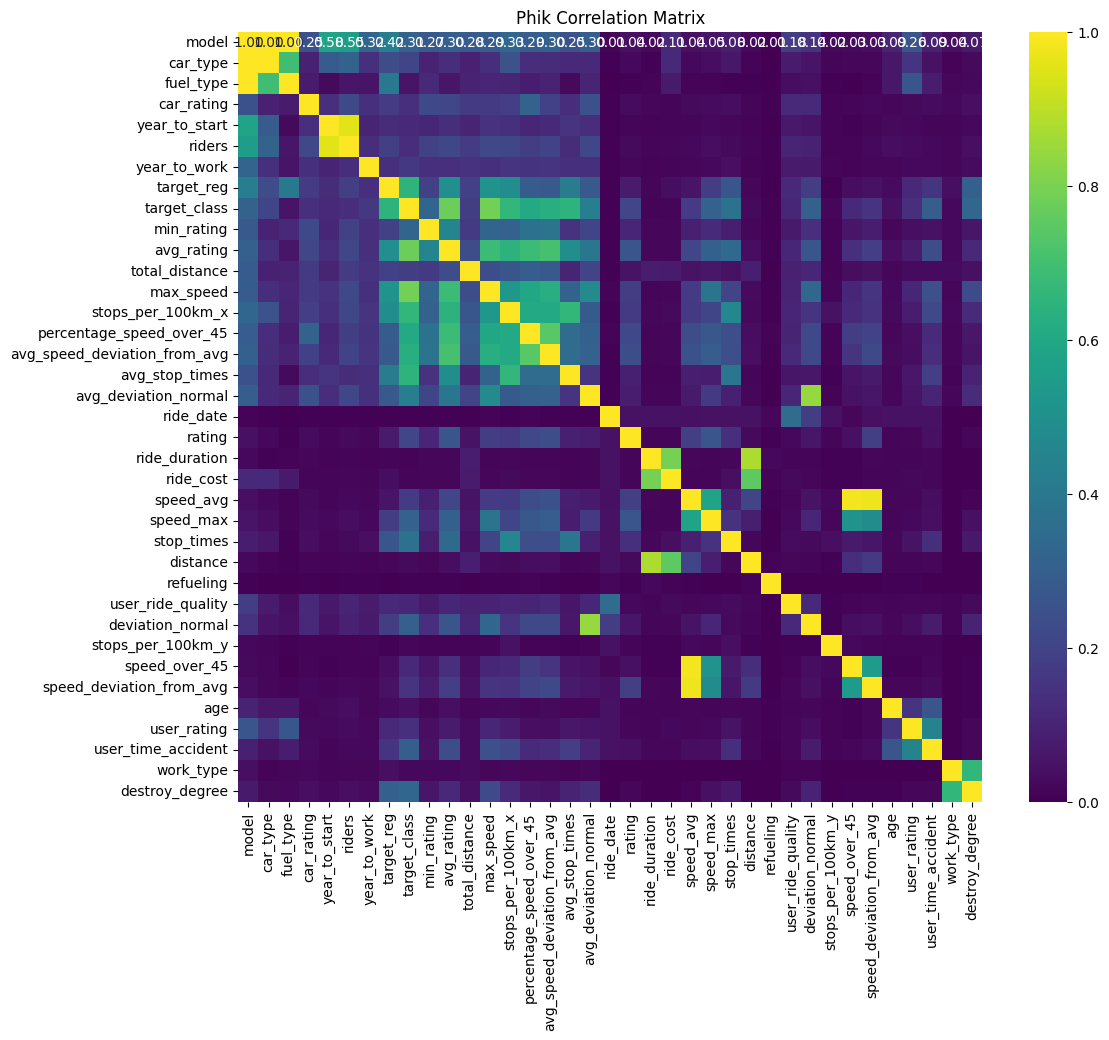

In [19]:
import phik
from phik import resources, report
import seaborn as sns

# Дропаю 'fix_date'
final_df_drop = final_df_cleaned.drop(columns=['fix_date'])

# Вычисляем корреляцию Phik 
phik_matrix = final_df_drop.phik_matrix()

# Отображение корреляционной матрицы Phik
print(phik_matrix)

# Визуализация корреляционной матрицы 
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Phik Correlation Matrix")
plt.show()

### Способ № 3 Permutation Importance

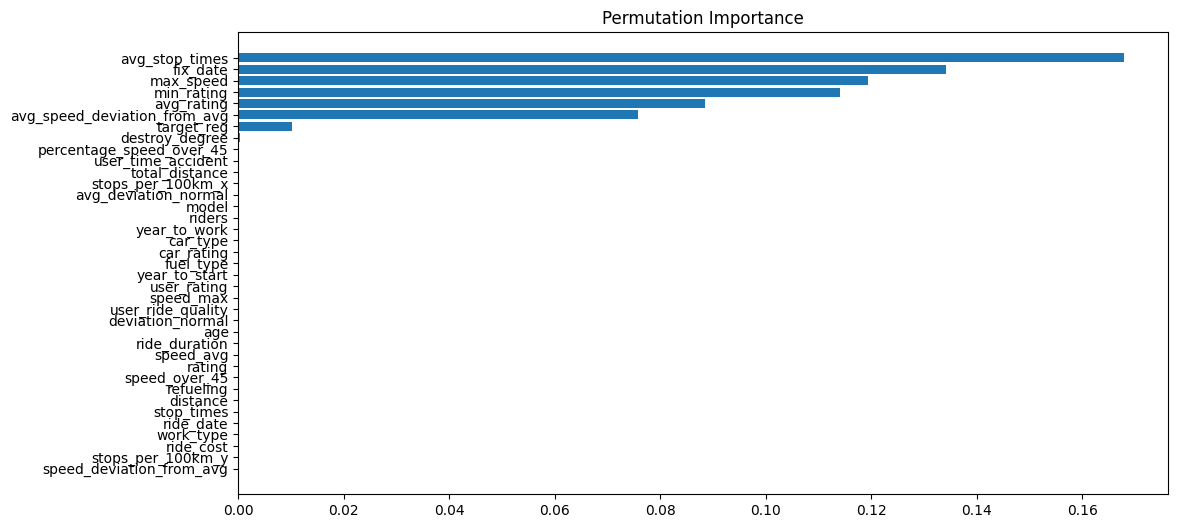

In [21]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [ ]:
# import shap
# # Создание объекта TreeExplainer 
# explainer = shap.TreeExplainer(model)

# # Вычисление SHAP values
# shap_values = explainer.shap_values(pool_test)

# # Визуализация средней абсолютной величины значений SHAP для каждого признака
# shap.summary_plot(shap_values, X_test, max_display=25)

**Вывод**: На мой взгляд, лучше всего показал себя метод с Catboost feature importance. Он более прост в использовании, не нужна и устойчив к различному типу данных. Также более наглядный и показательный, по моему мнению. 

- Наиболее значимыми признаками для модели, согласно полученным значениям важности признаков, являются target_class, avg_stop_times, total_distance, car_rating, и avg_deviation_normal. Эти признаки оказывают наибольшее влияние на прогнозируемую переменную, что указывает на их потенциальную релевантность и важность в контексте нашей задачи.

- Матрица корреляции Phik показывает взаимосвязи между различными признаками и целевой переменной. Например, признаки model, car_type, и fuel_type имеют высокие значения корреляции друг с другом, что может указывать на наличие мультиколлинеарности. Важно отметить, что Phik корреляция адаптирована для работы как с числовыми, так и с категориальными данными, предоставляя более широкий анализ взаимосвязей.

- Наличие высоких корреляций между некоторыми признаками, например между model, car_type, и fuel_type, может указывать на мультиколлинеарность, которая потенциально может влиять на стабильность и интерпретируемость модели. Возможно, стоит рассмотреть исключение или комбинацию некоторых из этих признаков для улучшения качества модели.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.